In [36]:
import polars.selectors as cs
import numpy as np

import polars as pl

import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib_inline.backend_inline

import matplotlib.pyplot as plt

LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False

In [37]:
def hist_of_numerical_values(df: pl.DataFrame):
    """
    Generates histograms for all numerical columns in a Polars DataFrame.

    Args:
        df: The Polars DataFrame.

    Returns:
        A dictionary where keys are column names and values are the histogram data.
    """
    histograms = {}
    for col_name in df.columns:
        if df[col_name].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]:
            hist_data = df[col_name].hist()
            histograms[col_name] = hist_data
    return histograms

In [38]:
index_cols = {
    20: []
}
scale_required = set([4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [20]
query_ind = 20

In [39]:
full_df = pl.DataFrame()
for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
    orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')

    noised = pl.read_json(f'../outputs/ap-duckdb-q{query_ind}-customer-{mi}-step3/output.json')
    orig = orig.with_row_index(name="rank")
    noised = noised.with_row_index(name="rank")
    merged_df = orig.join(noised, suffix='_noised',  on="rank", how='inner')
    suffix1 = ''
    suffix2 = '_noised'
    cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col and suffix2 in col]
    base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
    for base_name in base_names:
        nulls_exist = False
        null_inds, null_vals = [], []

        orig = base_name + suffix1
        noised = base_name + suffix2
        if orig in merged_df.columns and noised in merged_df.columns:
            rel_errors = []
            for ind in range(len(merged_df[orig])):
                try:
                    releases = merged_df[noised][ind].to_list()
                    filtered_releases = [x for x in releases if x is not None]
                except:
                    assert merged_df[noised][ind] is None
                    filtered_releases = []
                    
                
                if len(filtered_releases) == 0:
                    rel_errors.append(None)
                    continue
                actual = merged_df[orig][ind]
                pct_agreement = 100*releases.count(actual) / len(releases)
                rel_errors.append(pct_agreement)
            merged_df = merged_df.with_columns(pl.Series('pct_agreement_' + base_name, rel_errors))
        merged_df = merged_df.with_columns(pl.Series('mi', [mi]*len(rel_errors)))
    full_df = pl.concat([full_df, merged_df])

In [40]:
merged_df

rank,s_name,s_address,s_name_noised,s_address_noised,pct_agreement_s_address,mi,pct_agreement_s_name
u32,str,str,list[str],list[str],f64,f64,f64
0,"""Supplier#000000020""","""JtPqm19E7tF 152Rl1wQZ8j0H""","[""Supplier#000000020"", ""Supplier#000000354"", … ""Supplier#000000091""]","[""wSLcCW40Q8"", ""JtPqm19E7tF 152Rl1wQZ8j0H"", … ""35WVnU7GLNbQDcc2TARavGtk6RB6ZCd46UAY""]",25.9,4.0,26.2
1,"""Supplier#000000091""","""35WVnU7GLNbQDcc2TARavGtk6RB6ZC…","[""Supplier#000000287"", ""Supplier#000000205"", … ""Supplier#000000205""]","[""Alrx5TN,hdnG"", ""wSLcCW40Q8"", … ""UQR8bUA4V2HxVbw9K""]",16.5,4.0,15.5
2,"""Supplier#000000205""","""Alrx5TN,hdnG""","[""Supplier#000000354"", ""Supplier#000000354"", … ""Supplier#000000378""]","[""UQR8bUA4V2HxVbw9K"", ""0BvoewCPg2scOEfuL93FRKqSxHmdhw1"", … ""mLPJtpu4wOc cSFzBR""]",13.2,4.0,13.3
3,"""Supplier#000000285""","""q TMZEDyZtv vUiFKBhT3NJlnIxpL""","[""Supplier#000000640"", ""Supplier#000000555"", … ""Supplier#000000402""]","[""JR8vWoCteJtJg3okRpt0r28KEo"", ""wSLcCW40Q8"", … ""JR8vWoCteJtJg3okRpt0r28KEo""]",12.2,4.0,13.0
4,"""Supplier#000000287""","""UQR8bUA4V2HxVbw9K""","[""Supplier#000000378"", ""Supplier#000000736"", … ""Supplier#000000530""]","[""UQR8bUA4V2HxVbw9K"", ""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke"", … ""JR8vWoCteJtJg3okRpt0r28KEo""]",11.1,4.0,10.6
…,…,…,…,…,…,…,…
140,"""Supplier#000007398""","""6SMmUD1,,cmd60""",[null],[null],null,4.0,null
141,"""Supplier#000007402""","""X65wVTM tZAHEA8aV""",[null],[null],null,4.0,null
142,"""Supplier#000007448""","""uJJB4JhITmiUaV5pQa""",[null],[null],null,4.0,null


In [41]:
orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')
orig_key = ['s_name', 's_address']

agreement = {}

for key_ind, key in enumerate(['s_name_noised',  's_address_noised']): # ,
    ious = []
    for mi in  [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]: #
        merged_df = full_df.filter(pl.col('mi') == mi)
        responses = {}

        for rank in range(len(merged_df)): # for each rank supplier
            # 1000 possible responses or None
            rank_i_responses = merged_df[rank][key].to_list()[0]
            # if none, it's empty
            if rank_i_responses is None:
                continue
            # for each release ind
            for ind in range(len(rank_i_responses)):

                if ind not in responses:
                    responses[ind] = []
                if rank_i_responses[ind] is not None:
                    responses[ind].append(rank_i_responses[ind])
        # now ind corresponds to each release
        assert len(responses) == 1000
        for ind in responses:
            assert None not in responses[ind]
            responses[ind] = set(responses[ind])

        a = set(orig[orig_key[key_ind]].to_list())
        iou = []
        for t in responses:
            intersect = len(a.intersection(responses[t]))
            union = len(a.union(responses[t]))
            if union > len(a):
                print('union has more than orig data')
            iou.append(intersect/union)
        ious.append(100*np.average(iou))
    agreement[orig_key[key_ind]] = ious

In [42]:
len(merged_df[0]['s_name_noised'].to_list()[0])

1000

In [43]:
merged_df

rank,s_name,s_address,s_name_noised,s_address_noised,pct_agreement_s_address,mi,pct_agreement_s_name
u32,str,str,list[str],list[str],f64,f64,f64
0,"""Supplier#000000020""","""JtPqm19E7tF 152Rl1wQZ8j0H""","[""Supplier#000000020"", ""Supplier#000000354"", … ""Supplier#000000091""]","[""wSLcCW40Q8"", ""JtPqm19E7tF 152Rl1wQZ8j0H"", … ""35WVnU7GLNbQDcc2TARavGtk6RB6ZCd46UAY""]",25.9,4.0,26.2
1,"""Supplier#000000091""","""35WVnU7GLNbQDcc2TARavGtk6RB6ZC…","[""Supplier#000000287"", ""Supplier#000000205"", … ""Supplier#000000205""]","[""Alrx5TN,hdnG"", ""wSLcCW40Q8"", … ""UQR8bUA4V2HxVbw9K""]",16.5,4.0,15.5
2,"""Supplier#000000205""","""Alrx5TN,hdnG""","[""Supplier#000000354"", ""Supplier#000000354"", … ""Supplier#000000378""]","[""UQR8bUA4V2HxVbw9K"", ""0BvoewCPg2scOEfuL93FRKqSxHmdhw1"", … ""mLPJtpu4wOc cSFzBR""]",13.2,4.0,13.3
3,"""Supplier#000000285""","""q TMZEDyZtv vUiFKBhT3NJlnIxpL""","[""Supplier#000000640"", ""Supplier#000000555"", … ""Supplier#000000402""]","[""JR8vWoCteJtJg3okRpt0r28KEo"", ""wSLcCW40Q8"", … ""JR8vWoCteJtJg3okRpt0r28KEo""]",12.2,4.0,13.0
4,"""Supplier#000000287""","""UQR8bUA4V2HxVbw9K""","[""Supplier#000000378"", ""Supplier#000000736"", … ""Supplier#000000530""]","[""UQR8bUA4V2HxVbw9K"", ""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke"", … ""JR8vWoCteJtJg3okRpt0r28KEo""]",11.1,4.0,10.6
…,…,…,…,…,…,…,…
140,"""Supplier#000007398""","""6SMmUD1,,cmd60""",[null],[null],null,4.0,null
141,"""Supplier#000007402""","""X65wVTM tZAHEA8aV""",[null],[null],null,4.0,null
142,"""Supplier#000007448""","""uJJB4JhITmiUaV5pQa""",[null],[null],null,4.0,null


Q20
[46.239784946236554, 46.15913978494623, 46.01075268817203, 46.217741935483865, 46.3016129032258, 46.00913978494623, 46.280107526881714, 46.191935483870964, 46.159677419354836, 46.273118279569886]
reached
[46.31182795698924, 46.19408602150537, 46.3010752688172, 46.25752688172042, 46.22258064516129, 46.14677419354838, 46.21129032258064, 46.17688172043011, 46.195161290322574, 46.17204301075268]
reached


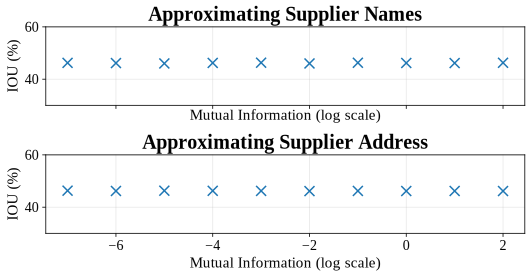

In [44]:
print("Q20")
mis = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]
xs = [np.log2(x) for x in mis]
fig, axes = plt.subplots(2, 1, figsize=(7.5, 4), sharex=True)
for ind, key in enumerate(['s_name', 's_address']):
    names = ["Names", "Address"]
    ax = axes[ind]
    print(agreement[key])
    ax.plot(xs, agreement[key], 'x', markersize=10, mew=1.5,
    )
    print('reached')
    
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
    ax.set_ylabel(f'IOU (%)', fontsize=15)
    ax.set_title(f'Approximating Supplier {names[ind]}', fontsize=20)
    ax.grid(True, alpha=0.3)
    ax.set_ylim((30, 60))
# plt.show()
plt.tight_layout()
plt.savefig('../figs/q20_results.png')



#         ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
#         ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
#         ax.set_title(f'Approximating {names[ind]} Line Count', fontsize=20)
#         ax.legend(fontsize=14)